In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import math
import itertools
import datetime
#from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime, timedelta, date

# Read endogenous and exogenous data and filter country/dates

In [2]:
# We read the endogenous data (coronavirus data)

covid_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid = pd.read_csv(covid_url, parse_dates=['date'], index_col=['date'])

In [42]:
# We filter the country, dates and the variable to predict

country = 'Spain'
variable = 'new_cases'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6))
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

# Filtering country and dates
covid_ctry = covid[covid['location']==country]
covid_ctry = covid_ctry.loc[initialdate:enddate]

# Filter the variable to predict and applying 7-day rolling mean
covid_ctry_var = covid_ctry[variable]
covid_ctry_varR = covid_ctry_var.rolling(7).mean().dropna()

In [43]:
# We now read the exogenous data, which is already 7-day rolling mean (for now, from a local file)

exogenous = pd.read_csv('./data/exogenas.csv', parse_dates=[0], index_col=[0])

In [44]:
# We now need to filter the country and adjust dates to endogenous covid_ctry_varR data:

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]
exogenous_ctryR = exogenous_ctry.loc[initialdateshift:enddate]

# We apply the 7-day rolling mean, as in the endogenous data
#exogenous_ctryR = exogenous_ctry.rolling(7).mean().dropna()

In [45]:
# We check that the only NaNs removed are the 6 positions created by the 7-rolling mean
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(226,) (226, 14)


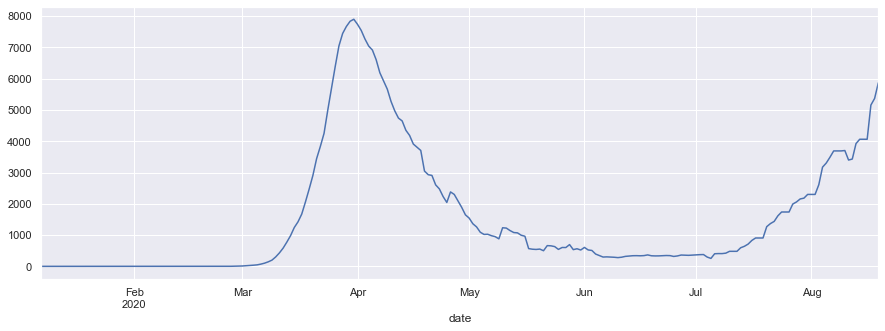

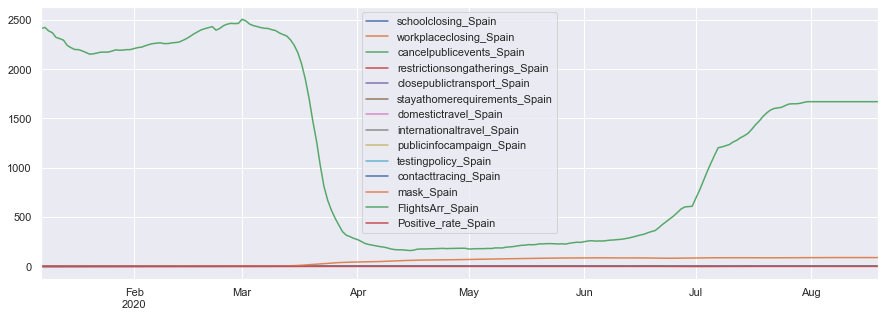

In [46]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [47]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [48]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR.values.reshape(-1,1))
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.name)
y = scaled_output.resample('1D').sum()

(226,) (226, 14)


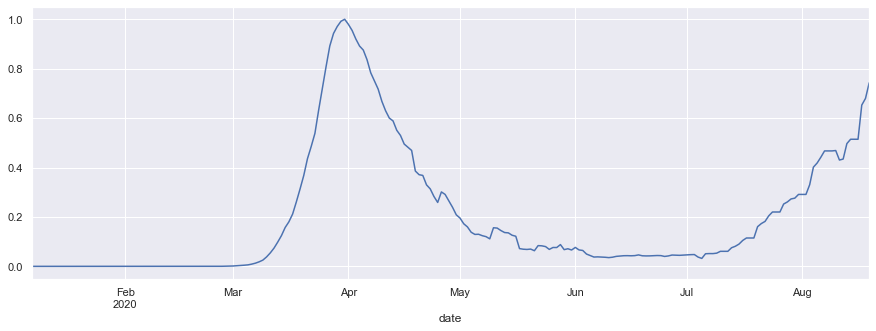

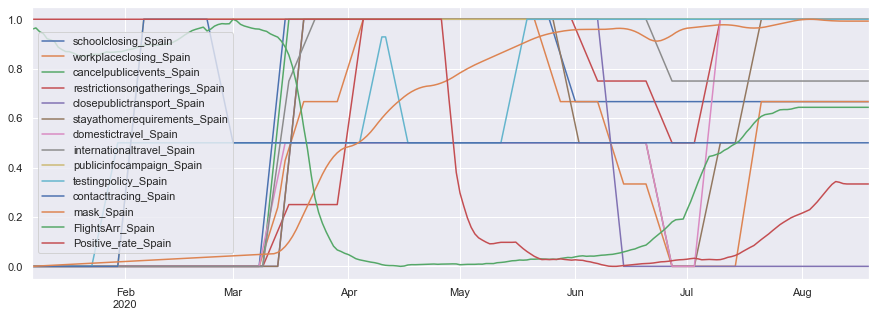

In [49]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [50]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [51]:
train_size, test_size

(192, 34)

# Stationarity: estimate differencing term (d)

In [52]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


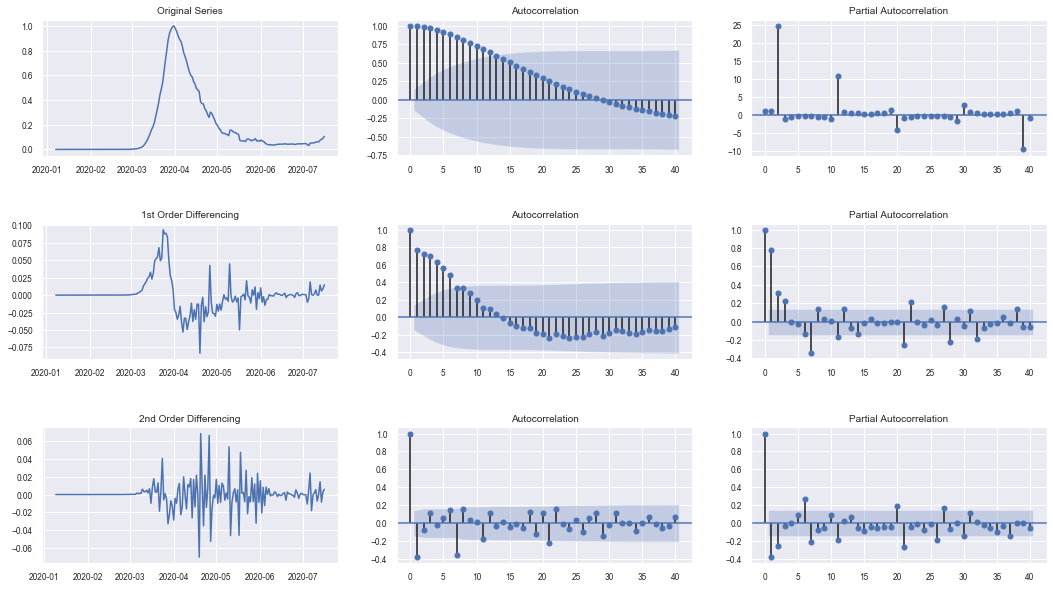

In [53]:
# Plotting ACF and PACF with the different 'd' values from previous step

plt.rcParams.update({'figure.figsize':(18,10), 'figure.subplot.hspace':0.5,
                     'xtick.labelsize':'x-small', 'ytick.labelsize':'x-small', 'axes.titlesize':'small'})
fig, axes = plt.subplots(3, 3)

# Original Series
axes[0, 0].plot(y_train); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(y_train, lags=40, ax=axes[0, 1])
sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(y_train.diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().dropna(), lags=40, ax=axes[1, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().dropna(), lags=40, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 2])
plt.show()
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

In [54]:
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

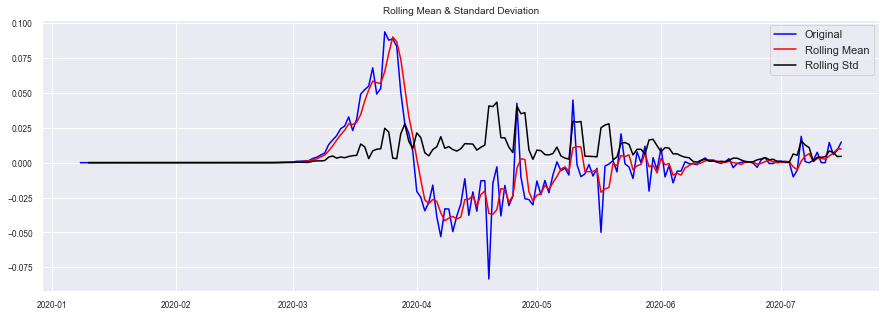

Result of Dicky=Fuller Test
Test Statistic           -3.216788
p-value                   0.019033
#Lags Used                7.000000
#Observations Used      183.000000
Critical Value (1%)      -3.466598
Critical Value (5%)      -2.877467
Critical Value (10%)     -2.575260
dtype: float64


In [55]:
test_stationarity(y_train.diff().dropna())

# Estimate order p and q of ARIMA model, using auto_arima

Fit ARIMA(0,0,0)x(0,0,0,1) [intercept=True]; AIC=-420.089, BIC=-367.969, Time=0.484 seconds
Fit ARIMA(0,0,1)x(0,0,0,1) [intercept=True]; AIC=-618.889, BIC=-563.512, Time=0.675 seconds
Fit ARIMA(0,0,2)x(0,0,0,1) [intercept=True]; AIC=-771.739, BIC=-713.104, Time=0.815 seconds
Fit ARIMA(0,0,3)x(0,0,0,1) [intercept=True]; AIC=-832.339, BIC=-770.446, Time=0.769 seconds
Fit ARIMA(0,0,4)x(0,0,0,1) [intercept=True]; AIC=-934.955, BIC=-869.805, Time=0.924 seconds
Fit ARIMA(0,0,5)x(0,0,0,1) [intercept=True]; AIC=-937.713, BIC=-869.306, Time=0.983 seconds
Fit ARIMA(1,0,0)x(0,0,0,1) [intercept=True]; AIC=-951.557, BIC=-896.180, Time=0.500 seconds
Fit ARIMA(1,0,1)x(0,0,0,1) [intercept=True]; AIC=-1006.298, BIC=-947.663, Time=0.645 seconds
Fit ARIMA(1,0,2)x(0,0,0,1) [intercept=True]; AIC=-1017.469, BIC=-955.577, Time=0.750 seconds
Fit ARIMA(1,0,3)x(0,0,0,1) [intercept=True]; AIC=-1034.924, BIC=-969.774, Time=0.833 seconds
Fit ARIMA(1,0,4)x(0,0,0,1) [intercept=True]; AIC=-1036.619, BIC=-968.211, Tim

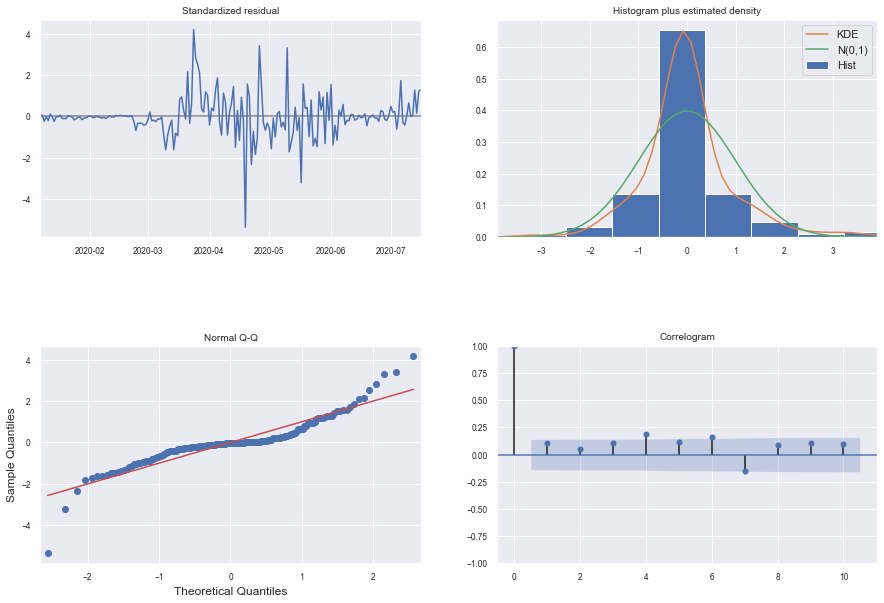

In [63]:
modelauto7 = pm.auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                      test='adf',       # use kpss to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(modelauto7.summary())
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

# Train and fit SARIMAX model with previous selected (p,d,q) orders

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  192
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 556.939
Date:                Thu, 20 Aug 2020   AIC                          -1081.879
Time:                        16:18:27   BIC                          -1029.926
Sample:                    01-07-2020   HQIC                         -1060.834
                         - 07-16-2020                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain                0.0077      0.098      0.078      0.938      -0.185       0.200
workplaceclosing_Spain             0.0417      0.089      0.471      0.

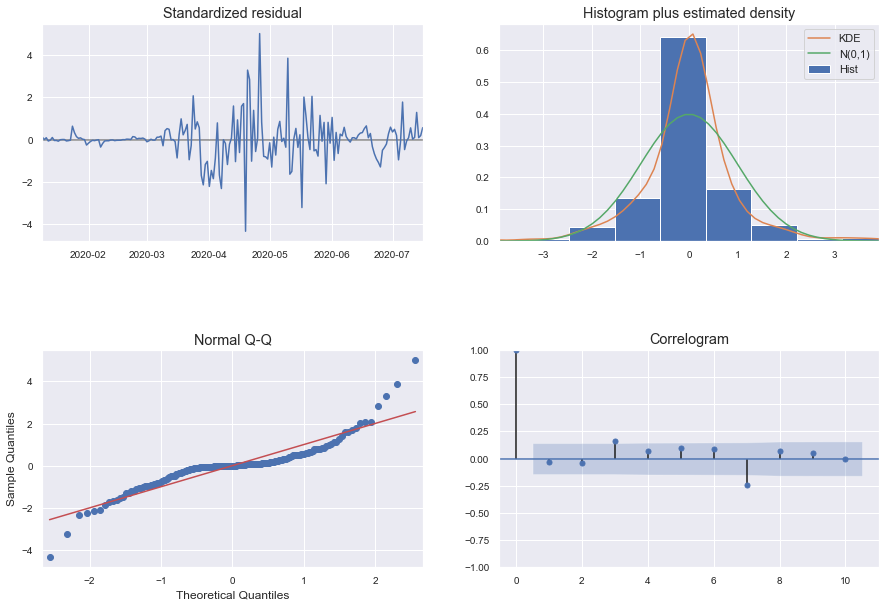

In [74]:
model1 = sm.tsa.statespace.SARIMAX(y_train, order=(0,2,1), exog=X_train)
results1 = model1.fit()
print(results1.summary())
results1.plot_diagnostics(figsize=(15,10));

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  192
Model:               SARIMAX(0, 2, 3)   Log Likelihood                 563.294
Date:                Thu, 20 Aug 2020   AIC                          -1090.587
Time:                        16:16:48   BIC                          -1032.141
Sample:                    01-07-2020   HQIC                         -1066.912
                         - 07-16-2020                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain               -0.0189      0.091     -0.207      0.836      -0.198       0.160
workplaceclosing_Spain             0.0725      0.091      0.800      0.

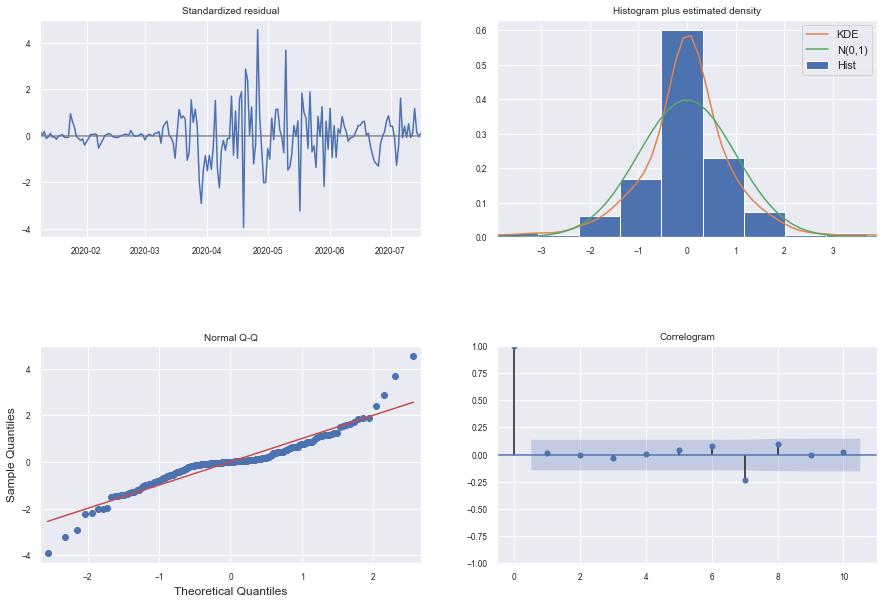

In [65]:
model2 = sm.tsa.statespace.SARIMAX(y_train, order=(0,2,3), exog=X_train)
results2 = model2.fit()
print(results2.summary())
results2.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model RMSE

In [66]:
train_size, test_size, X_test.shape

(192, 34, (34, 14))

In [75]:
# Select best model
results_best = results1

In [76]:
# Generate in-sample predictions (train) and evaluate RMSE:

in_predictions = results_best.predict(exog=X_train)

print("Train RMSE: %.3f" % np.sqrt(mean_squared_error(y_train, in_predictions)))

Train RMSE: 0.027


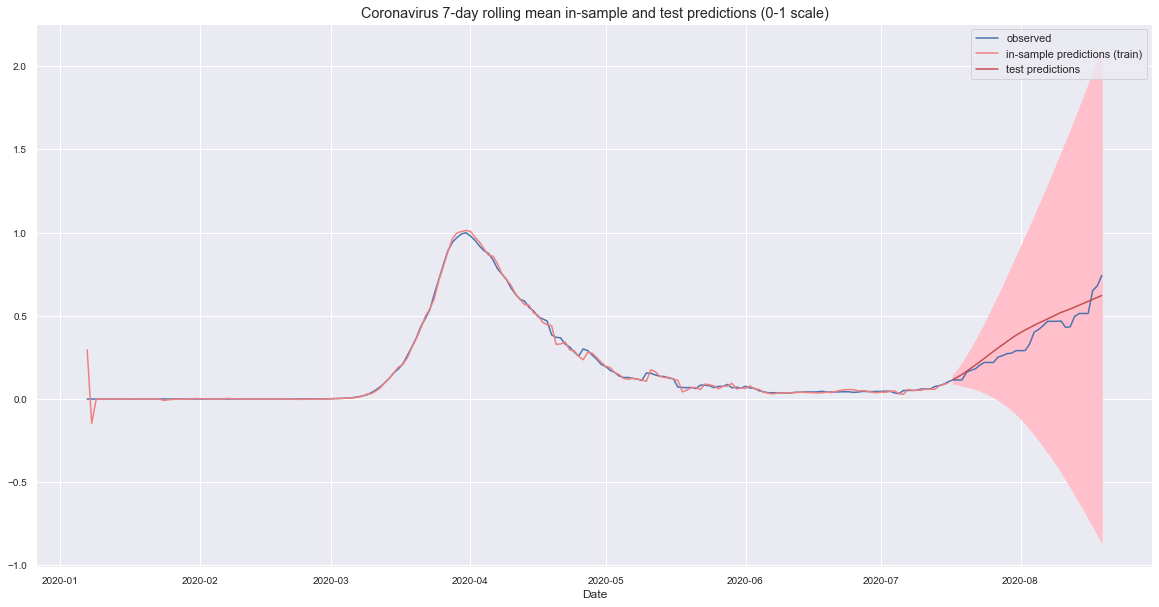

In [77]:
# Generate forecast for the test sample, updating our model by simulating days passing with our test set:

#def forecast_one_step(i):
#    forecast = results2.get_forecast(steps=1, exog=X_test.iloc[i].values.reshape(1,-1))
#    fc = forecast.predicted_mean
#    conf_int = forecast.conf_int()
#    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

#forecasts = []
#confidence_intervals = []
#i = 0

#for new_ob in y_test:
#    fc, conf = forecast_one_step(i)
#    forecasts.append(fc)
#    confidence_intervals.append(conf)

    # Update the existing model
#    results2.append(new_ob, exog=X_test.iloc[i].values.reshape(1,-1))
#    i = i+1


# Generate forecast for the test sample
#one_step_forecast = results2.get_prediction(start=train_size, end=train_size+test_size-1, exog=X_test)
one_step_forecast = results_best.get_forecast(steps=test_size, exog=X_test)


# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
#print(mean_predict.values)

# plot the data
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'figure.figsize':(20,10), 'xtick.labelsize':'small', 'ytick.labelsize':'small', 'axes.titlesize':'large'})
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train)
plt.plot(in_predictions.index, in_predictions, color='lightcoral', label= 'in-sample predictions (train)')

# plot mean predictions (test)
plt.plot(mean_forecast.index, mean_forecast, color='r', label='test predictions')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.legend()
plt.show()

In [78]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y[train_size:], mean_forecast.values)))

Test RMSE: 0.065


# Scale data back to original values

In [79]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.name)

In [80]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.name)

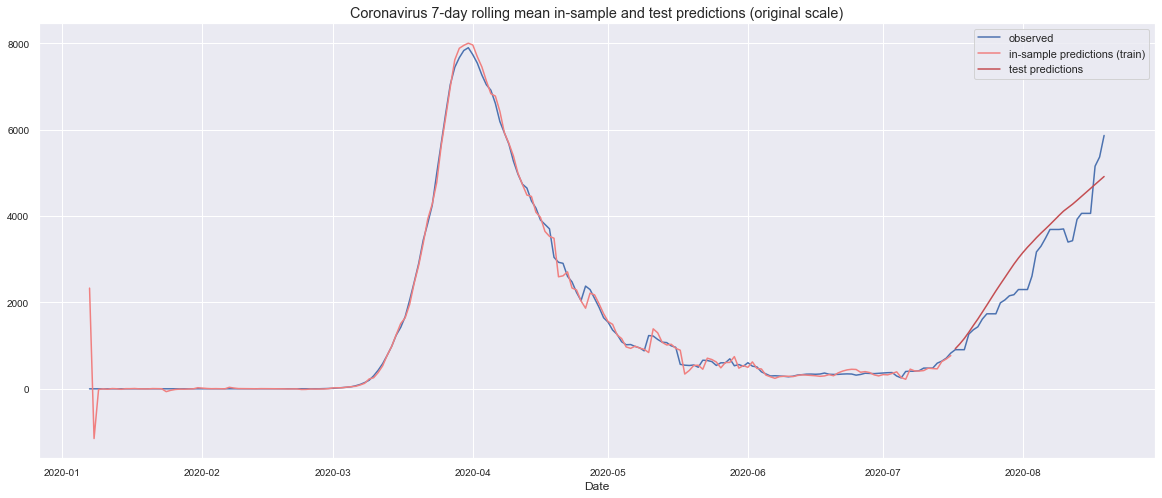

In [81]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [82]:
print("Test RMSE (original scale): %.3f" % np.sqrt(mean_squared_error(covid_ctry_varR[train_size:], testPredictS)))

Test RMSE (original scale): 513.500


# Save model so we can then update with future values

In [126]:
%pwd

'C:\\Users\\marta\\Documents\\MasterDataScience\\project\\KSchool-Master-Final-Project'

In [83]:
# Set model name
filename = './models/SpainSARIMAXmodel.pkl'

# Pickle it
joblib.dump(results_best, filename)

['./models/SpainSARIMAXmodel.pkl']

In [84]:
# Load the model back in
loaded_model = joblib.load(filename)

# Update the model
#loaded_model.update(__dfnew___)

In [85]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  192
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 556.939
Date:                Thu, 20 Aug 2020   AIC                          -1081.879
Time:                        16:20:38   BIC                          -1029.926
Sample:                    01-07-2020   HQIC                         -1060.834
                         - 07-16-2020                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain                0.0077      0.098      0.078      0.938      -0.185       0.200
workplaceclosing_Spain             0.0417      0.089      0.471      0.637      -0.132       0.215
cancelpublicevents_Spain           0.1845      0.248      0.745      0.456      -0.301       0.670
restrictionsongatherings_Spain    -0.0167      0.071     -0.236      0.813      -0.155       0.122
closepublictransport_Spain        -0.0243      0.157     -0.155      0.877      -0.331       0.283
stayathomerequirements_Spain      -0.0299      0.143     -0.209      0.835      -0.311       0.251
domestictravel_Spain               0.0499      0.105      0.475      0.635      -0.156       0.256
internationaltravel_Spain         -0.2544      0.302     -0.841      0.400      -0.847       0.338
publicinfocampaign_Spain          -0.0723      1.262     -0.057      0.954      -2.546       2.401
testingpolicy_Spain               -0.1140      0.057     -1.992      0.046      -0.226      -0.002
contacttracing_Spain               0.0395      1.246      0.032      0.975      -2.402       2.481
mask_Spain                         1.8798      0.438      4.296      0.000       1.022       2.737
FlightsArr_Spain                   0.0929      0.250      0.371      0.710      -0.398       0.584
Positive_rate_Spain                0.2061      0.072      2.866      0.004       0.065       0.347
ma.L1                             -0.5203      0.045    -11.561      0.000      -0.609      -0.432
sigma2                             0.0002    9.1e-06     18.268      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       82.30   Jarque-Bera (JB):               318.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              28.93   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Update model with test observations, to get it ready for future forecasts

In [86]:
# Update model with test sample and re-fit parameters:
res_updated = results_best.append(y_test, exog=X_test, refit=True)

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  226
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 591.008
Date:                Thu, 20 Aug 2020   AIC                          -1150.016
Time:                        16:20:52   BIC                          -1095.429
Sample:                    01-07-2020   HQIC                         -1127.982
                         - 08-19-2020                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain               -0.0094      0.171     -0.055      0.956      -0.345       0.326
workplaceclosing_Spain             0.0784      0.132      0.595      0.

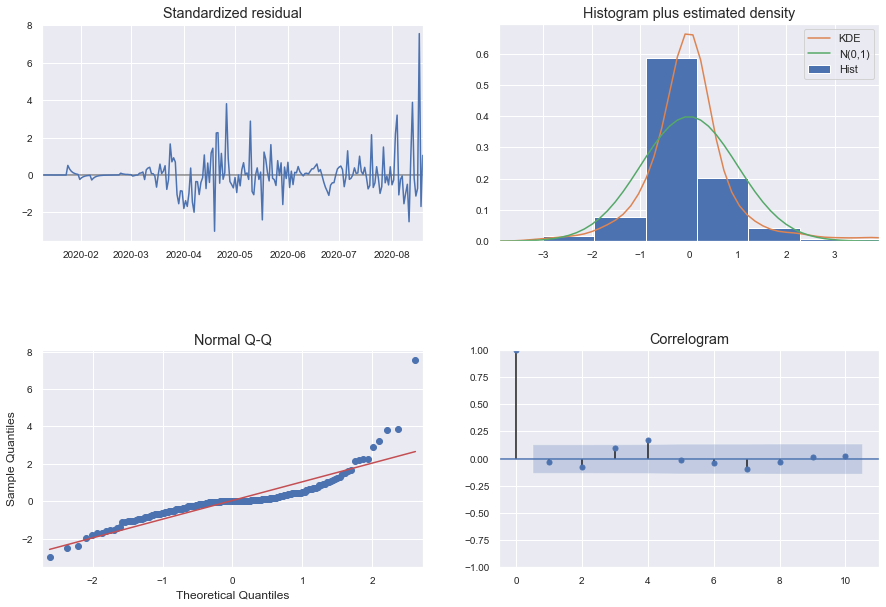

In [87]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

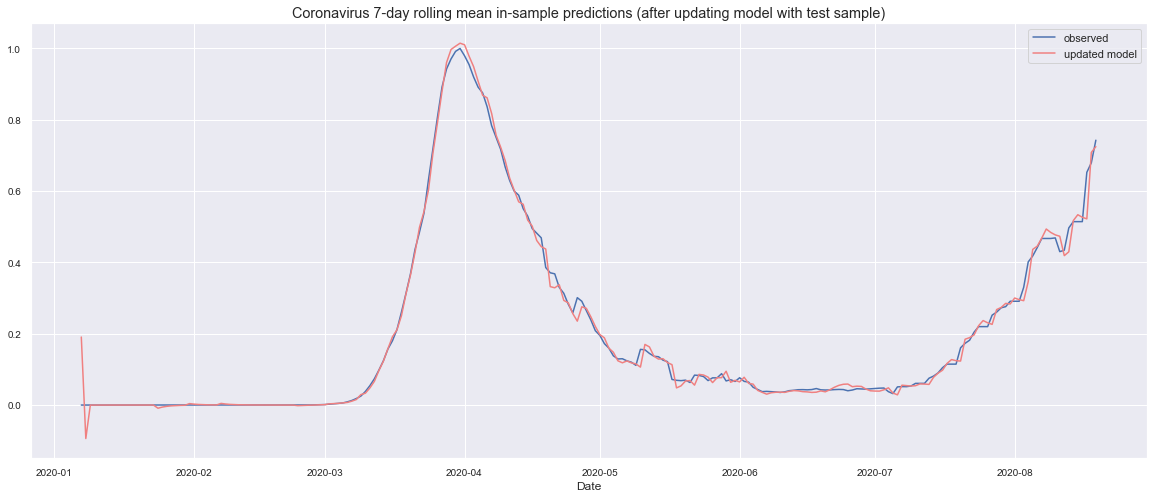

In [88]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [89]:
# Save model again, after updating it with test sample:
#filename = './SpainSARIMAXmodel2.pkl'

# Pickle it
joblib.dump(res_updated, filename)

['./models/SpainSARIMAXmodel.pkl']

# Perform forecast

In [89]:
#exog_forecast = exogenous.loc['2020-07-25':'2020-08-07', exogenous.columns.str.contains(country)]
#exog_forecast.loc[:, exog_forecast.columns.str.contains('Flights')] = \
                   exog_forecast.loc[:, exog_forecast.columns.str.contains('Flights')]\
                  .shift(7, fill_value=exog_forecast.loc['2020-07-25':'2020-07-31', exog_forecast.columns.str.contains('Flights')])
#exog_forecast = exog_forecast.iloc[1:, :]

#exog_forecastR = exog_forecast.rolling(7).mean().dropna()
#exog_forecastR

,schoolclosing_Spain,workplaceclosing_Spain,cancelpublicevents_Spain,restrictionsongatherings_Spain,closepublictransport_Spain,stayathomerequirements_Spain,domestictravel_Spain,internationaltravel_Spain,publicinfocampaign_Spain,testingpolicy_Spain,contacttracing_Spain,mask_Spain,FlightsArr_Spain
2020-08-01,2.0,2.0,2.0,4.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,89.530612,1670.571429
2020-08-02,2.0,2.0,2.0,4.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,89.632653,1670.571429
2020-08-03,2.0,2.0,2.0,4.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,89.673469,1670.571429
2020-08-04,2.0,2.0,2.0,4.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,89.653061,1670.571429
2020-08-05,2.0,2.0,2.0,4.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,89.571429,1670.571429
2020-08-06,2.0,2.0,2.0,4.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,89.428571,1670.571429
2020-08-07,2.0,2.0,2.0,4.0,0.0,2.0,2.0,3.0,2.0,2.0,1.0,89.306122,1670.571429


In [99]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdateshift, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

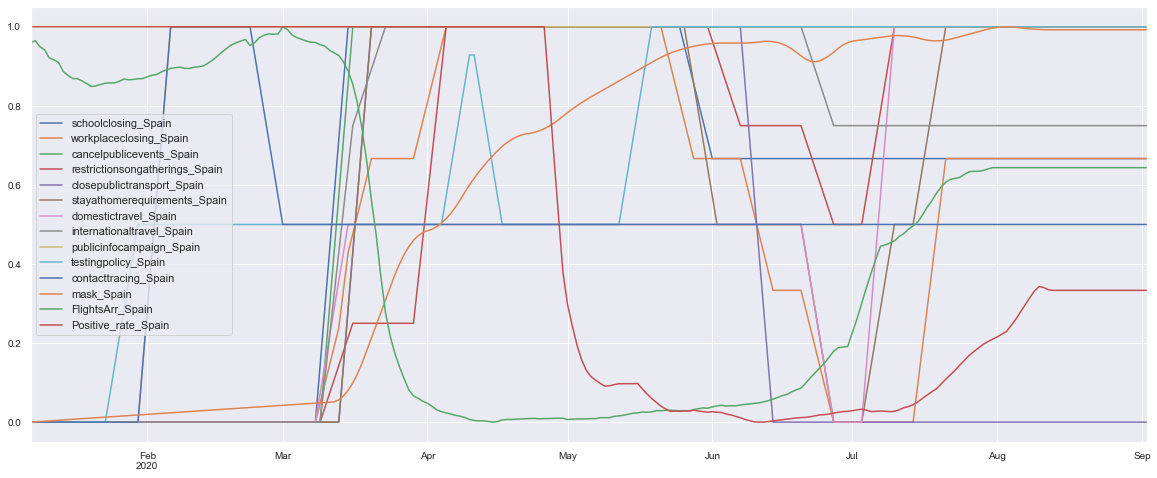

In [97]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.79453961 0.84635586 0.89817211 0.94998836 1.00180461 1.05362086
 1.10543711 1.15725336 1.2090696  1.26088585 1.3127021  1.36451835
 1.4163346  1.46815085]


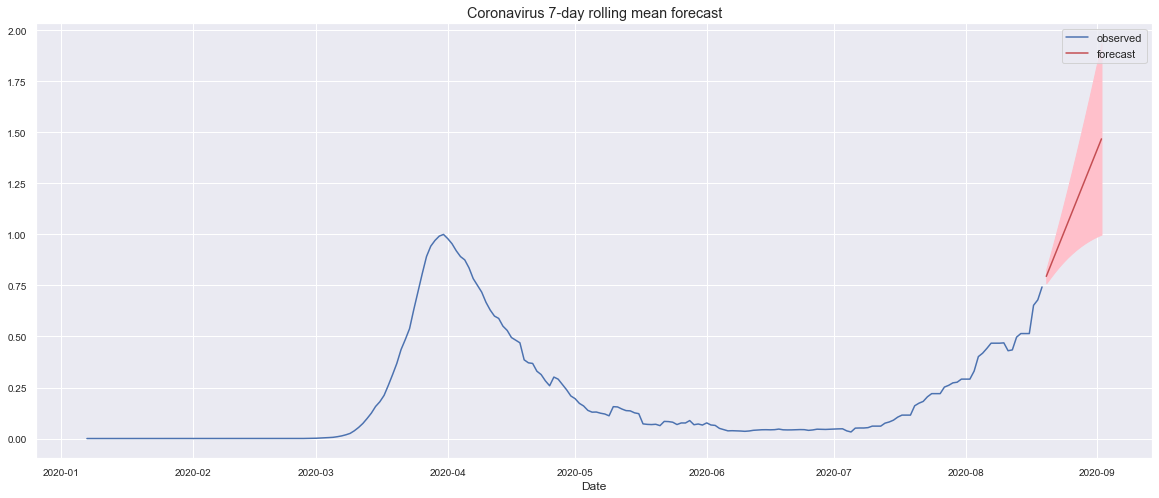

In [100]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [101]:
sm.__version__

'0.11.1'

In [102]:
pm.__version__

'1.6.1'